In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import time
import psutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
labels = ['Early_Blight','Healthy','Late_Blight']

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Validation',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 163/163 [00:01<00:00, 155.05it/s]


In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4398, 128, 128, 3)
(4398,)
(486, 128, 128, 3)
(486,)


In [6]:
# Reshape X_train
nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny*nrgb))

# Reshape X_test
nsamples, nx, ny, nrgb= X_test.shape
X_test = X_test.reshape(nsamples, nx*ny*nrgb)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4398, 49152)
(4398,)
(486, 49152)
(486,)


In [8]:
all_model = pd.DataFrame(columns=['Model', 'Accuracy (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)', 'Training Time (s)', 'Testing Time (s)','Memory (MB)'])

In [9]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)


**Machine Learning**

**SVM**

In [10]:
from sklearn.svm import SVC

# define the SVM model
svm = SVC(
    kernel='rbf',            
    C=1.0,                    
    gamma='scale',            
    decision_function_shape='ovr'
)

# fit the model on the training data
start_time = time.time()
svm.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

In [11]:
# make predictions on the test data
start_time = time.time()
y_pred = svm.predict(X_test)
testing_time = time.time() - start_time

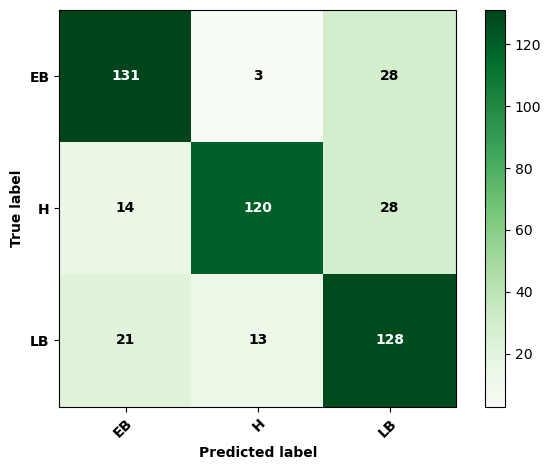

In [12]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [13]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 77.9835
Precision (Test): 78.9054
Recall (Test): 77.9835
F1 score (Test): 78.1345


In [14]:
# make predictions on the train data
y_pred = svm.predict(X_train)

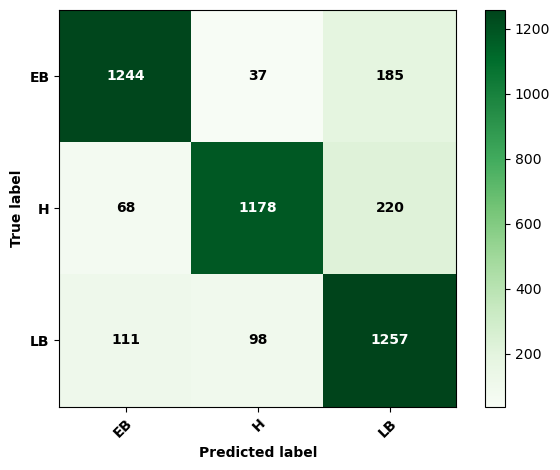

In [15]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [16]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 83.6517
Precision (Train): 84.2570
Recall (Train): 83.6517
F1 score (Train): 83.7564


In [17]:
model_name='SVM'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [18]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,SVM,83.65166,84.256971,83.65166,83.756435,77.983539,78.905391,77.983539,78.134467,315.554209,142.788555,2236.230469


**KNN**

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# define the KNN model
knn = KNeighborsClassifier()

# fit the model on the training data
start_time = time.time()
knn.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

In [20]:
# make predictions on the test data
start_time = time.time()
y_pred = knn.predict(X_test)
testing_time = time.time() - start_time

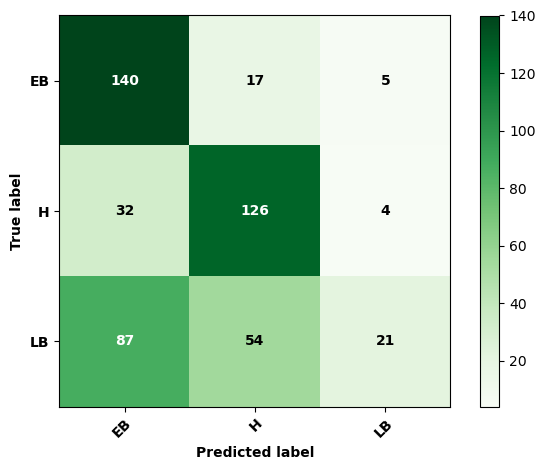

In [21]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [22]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 59.0535
Precision (Test): 62.6711
Recall (Test): 59.0535
F1 score (Test): 52.8594


In [23]:
# make predictions on the train data
y_pred = knn.predict(X_train)

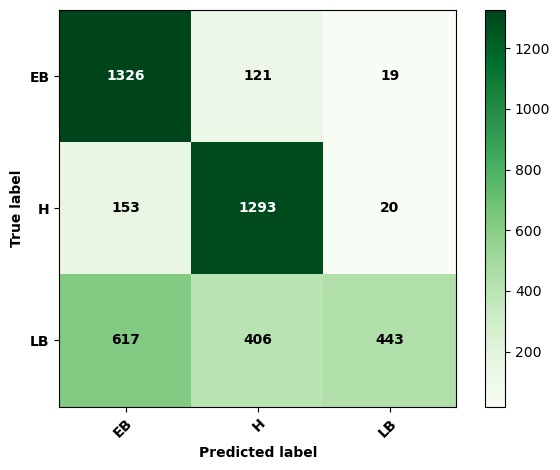

In [24]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [25]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 69.6226
Precision (Train): 75.4053
Recall (Train): 69.6226
F1 score (Train): 66.2109


In [26]:
model_name='KNN'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [27]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,SVM,83.651660,84.256971,83.651660,83.756435,77.983539,78.905391,77.983539,78.134467,315.554209,142.788555,2236.230469
1,KNN,69.622556,75.405343,69.622556,66.210869,59.053498,62.671148,59.053498,52.859433,0.002137,4.173776,2242.195312


**Logistic Regression**

In [28]:
from sklearn.linear_model import LogisticRegression

# define the LR model
lr = LogisticRegression(
    multi_class='multinomial',  
    solver='lbfgs',             
    C=1.0,                      
    max_iter=200,               
    random_state=42             
)


# fit the model on the training data
start_time = time.time()
lr.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
# make predictions on the test data
start_time = time.time()
y_pred = lr.predict(X_test)
testing_time = time.time() - start_time

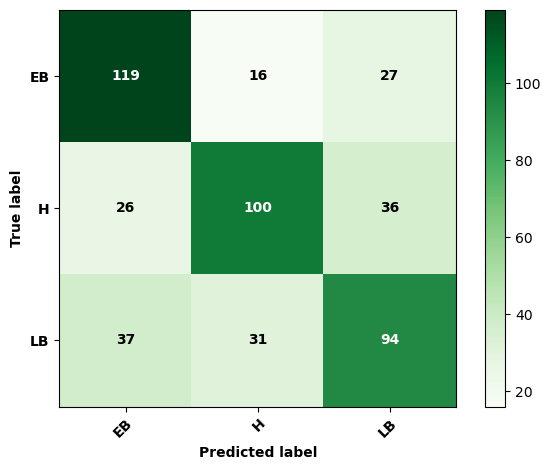

In [30]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [31]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 64.4033
Precision (Test): 64.4281
Recall (Test): 64.4033
F1 score (Test): 64.2817


In [32]:
# make predictions on the train data
y_pred = lr.predict(X_train)

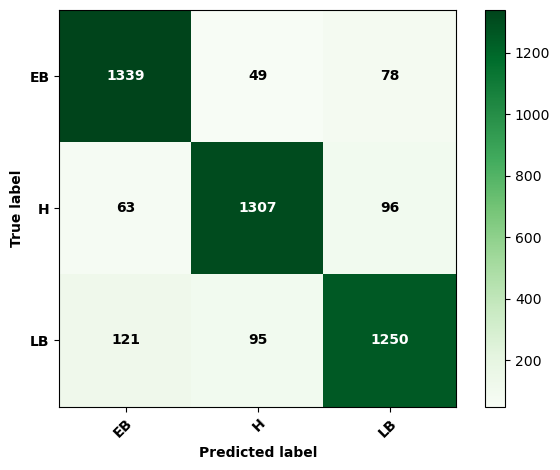

In [33]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [34]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 88.5857
Precision (Train): 88.5918
Recall (Train): 88.5857
F1 score (Train): 88.5710


In [35]:
model_name='LR'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [36]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,SVM,83.651660,84.256971,83.651660,83.756435,77.983539,78.905391,77.983539,78.134467,315.554209,142.788555,2236.230469
1,KNN,69.622556,75.405343,69.622556,66.210869,59.053498,62.671148,59.053498,52.859433,0.002137,4.173776,2242.195312
2,LR,88.585721,88.591763,88.585721,88.570996,64.403292,64.428146,64.403292,64.281712,154.806865,0.070814,3911.617188


**Gaussian Naive Bayes**

In [37]:
from sklearn.naive_bayes import GaussianNB

# define the GNB model
gnb = GaussianNB(var_smoothing=1e-8)

# fit the model on the training data
start_time = time.time()
gnb.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

In [38]:
# make predictions on the test data
start_time = time.time()
y_pred = gnb.predict(X_test)
testing_time = time.time() - start_time

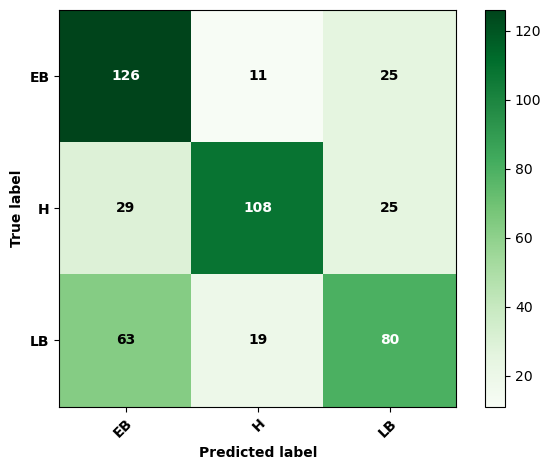

In [39]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [40]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 64.6091
Precision (Test): 65.8658
Recall (Test): 64.6091
F1 score (Test): 64.3701


In [41]:
# make predictions on the train data
y_pred = gnb.predict(X_train)

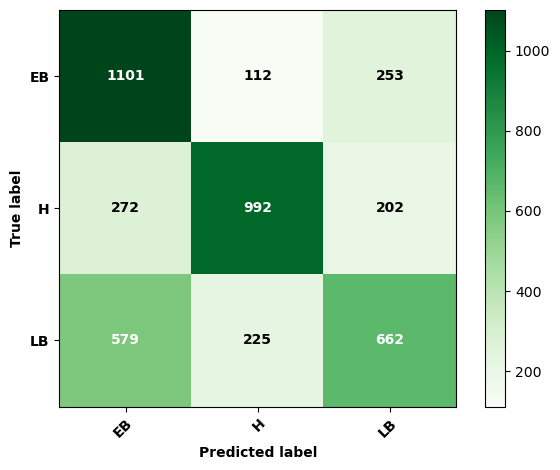

In [42]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [43]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 62.6421
Precision (Train): 63.4374
Recall (Train): 62.6421
F1 score (Train): 62.2219


In [44]:
model_name='NB'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [45]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,SVM,83.651660,84.256971,83.651660,83.756435,77.983539,78.905391,77.983539,78.134467,315.554209,142.788555,2236.230469
1,KNN,69.622556,75.405343,69.622556,66.210869,59.053498,62.671148,59.053498,52.859433,0.002137,4.173776,2242.195312
2,LR,88.585721,88.591763,88.585721,88.570996,64.403292,64.428146,64.403292,64.281712,154.806865,0.070814,3911.617188
3,NB,62.642110,63.437389,62.642110,62.221922,64.609053,65.865832,64.609053,64.370103,2.259723,0.476847,2262.410156


**Decision Tree**

In [46]:
from sklearn.tree import DecisionTreeClassifier

# define the DT model
dt = DecisionTreeClassifier(
    criterion='gini',            
    max_depth=20,                
    min_samples_split=5,         
    min_samples_leaf=3,          
    max_features='sqrt',         
    random_state=42              
)

# fit the model on the training data
start_time = time.time()
dt.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

In [47]:
# make predictions on the test data
start_time = time.time()
y_pred = dt.predict(X_test)
testing_time = time.time() - start_time

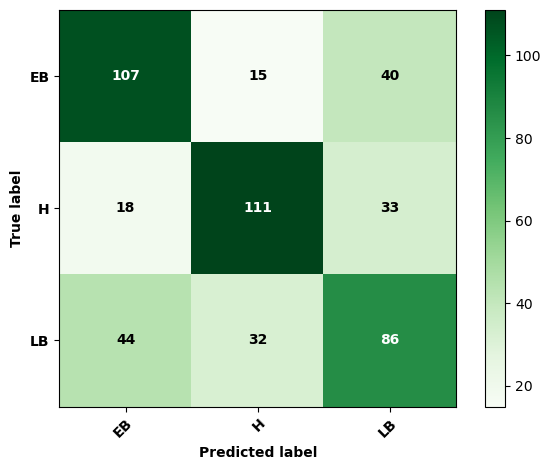

In [48]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [49]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 62.5514
Precision (Test): 62.5516
Recall (Test): 62.5514
F1 score (Test): 62.5367


In [50]:
# make predictions on the train data
y_pred = dt.predict(X_train)

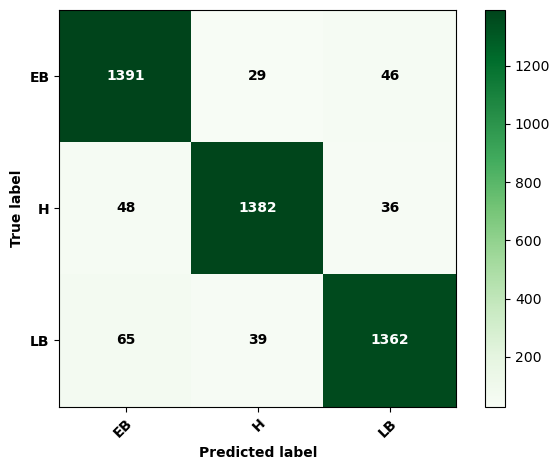

In [51]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [52]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 94.0200
Precision (Train): 94.0395
Recall (Train): 94.0200
F1 score (Train): 94.0219


In [53]:
model_name='DT'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [54]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,SVM,83.651660,84.256971,83.651660,83.756435,77.983539,78.905391,77.983539,78.134467,315.554209,142.788555,2236.230469
1,KNN,69.622556,75.405343,69.622556,66.210869,59.053498,62.671148,59.053498,52.859433,0.002137,4.173776,2242.195312
2,LR,88.585721,88.591763,88.585721,88.570996,64.403292,64.428146,64.403292,64.281712,154.806865,0.070814,3911.617188
3,NB,62.642110,63.437389,62.642110,62.221922,64.609053,65.865832,64.609053,64.370103,2.259723,0.476847,2262.410156
4,DT,94.020009,94.039459,94.020009,94.021887,62.551440,62.551608,62.551440,62.536707,1.196298,0.037713,2264.023438


**MLP**

In [55]:
from sklearn.neural_network import MLPClassifier
mlp =MLPClassifier(
    hidden_layer_sizes=(128, 64),  
    activation='relu',             
    solver='adam',                 
    alpha=0.0001,                  
    batch_size=64,                 
    learning_rate='adaptive',      
    max_iter=300,                  
    early_stopping=True,           
    random_state=42                
)
start_time = time.time()
mlp.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

In [56]:
# make predictions on the test data
start_time = time.time()
y_pred = mlp.predict(X_test)
testing_time = time.time() - start_time

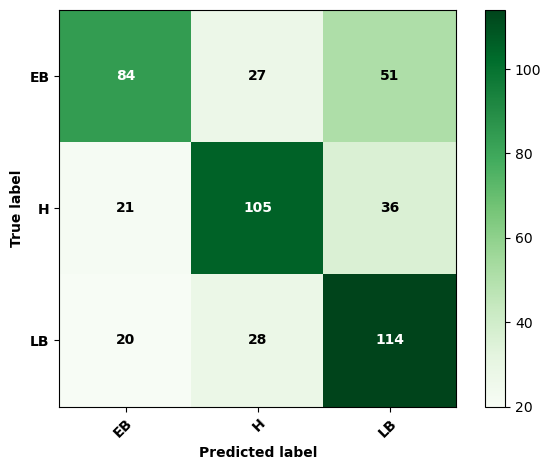

In [57]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [58]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 62.3457
Precision (Test): 63.1805
Recall (Test): 62.3457
F1 score (Test): 62.1880


In [59]:
# make predictions on the train data
y_pred = mlp.predict(X_train)

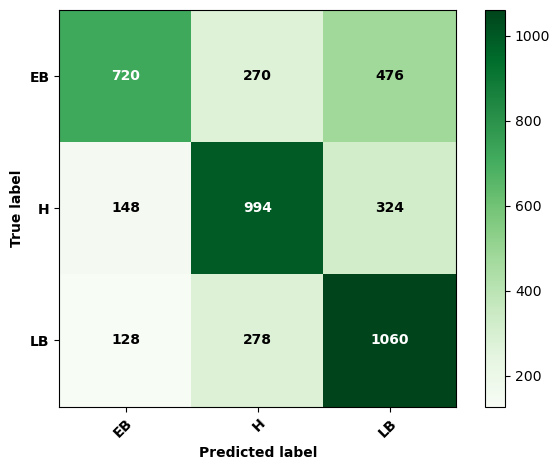

In [60]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [61]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 63.0741
Precision (Train): 64.5800
Recall (Train): 63.0741
F1 score (Train): 62.7732


In [62]:
model_name='MLP'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [63]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,SVM,83.651660,84.256971,83.651660,83.756435,77.983539,78.905391,77.983539,78.134467,315.554209,142.788555,2236.230469
1,KNN,69.622556,75.405343,69.622556,66.210869,59.053498,62.671148,59.053498,52.859433,0.002137,4.173776,2242.195312
2,LR,88.585721,88.591763,88.585721,88.570996,64.403292,64.428146,64.403292,64.281712,154.806865,0.070814,3911.617188
3,NB,62.642110,63.437389,62.642110,62.221922,64.609053,65.865832,64.609053,64.370103,2.259723,0.476847,2262.410156
4,DT,94.020009,94.039459,94.020009,94.021887,62.551440,62.551608,62.551440,62.536707,1.196298,0.037713,2264.023438
5,MLP,63.074125,64.580047,63.074125,62.773229,62.345679,63.180473,62.345679,62.187965,237.268486,0.158095,2423.171875
